In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-rs/user_profile.csv
/kaggle/input/dataset-rs/raw_sample.csv
/kaggle/input/dataset-rs/UserBehavior.csv
/kaggle/input/dataset-rs/ad_feature.csv


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [3]:
# 🔹 Step 1: Load & Preprocess Data
ad_data = pd.read_csv("raw_sample.csv", usecols=["user", "adgroup_id", "nonclk"])
ecommerce_data = pd.read_csv("UserBehavior.csv")
ecommerce_data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']


In [4]:
# Rename columns for consistency
ad_data.rename(columns={"user": "user_id", "adgroup_id": "item_id", "nonclk": "interaction"}, inplace=True)
ecommerce_data["interaction"] = ecommerce_data["behavior_type"].apply(lambda x: 1 if x == "buy" else 0)

# Keep only relevant columns
ad_data = ad_data[["user_id", "item_id", "interaction"]]
ecommerce_data = ecommerce_data[["user_id", "item_id", "interaction"]]


In [5]:
# 🔹 Step 2: Filter Common Users & Sample 20%
common_users = list(set(ad_data["user_id"]).intersection(set(ecommerce_data["user_id"])))
sampled_users = np.random.choice(common_users, int(0.3 * len(common_users)), replace=False)
ad_data = ad_data[ad_data["user_id"].isin(sampled_users)]
ecommerce_data = ecommerce_data[ecommerce_data["user_id"].isin(sampled_users)]

In [6]:
# Print dataset sizes
print(f"Sampled users: {len(sampled_users)}")
print(f"Ad interactions after sampling: {len(ad_data)}")
print(f"E-commerce interactions after sampling: {len(ecommerce_data)}")

Sampled users: 296398
Ad interactions after sampling: 6819890
E-commerce interactions after sampling: 30026756


In [6]:
# 🔹 Step 3: Train User Embeddings Using SVD
def train_user_embeddings(data, embedding_dim=32):
    data = data.groupby(["user_id", "item_id"]).agg({"interaction": "sum"}).reset_index()
    user_mapping = {user: idx for idx, user in enumerate(data["user_id"].unique())}
    item_mapping = {item: idx for idx, item in enumerate(data["item_id"].unique())}
    data["user_idx"] = data["user_id"].map(user_mapping)
    data["item_idx"] = data["item_id"].map(item_mapping)

    interaction_matrix = csr_matrix(
        (data["interaction"], (data["user_idx"], data["item_idx"])),
        shape=(len(user_mapping), len(item_mapping))
    )

    svd = TruncatedSVD(n_components=embedding_dim, random_state=42)
    user_embeddings = svd.fit_transform(interaction_matrix)

    return {user: embedding for user, embedding in zip(user_mapping.keys(), user_embeddings)}

# Train embeddings
source_user_embeddings = train_user_embeddings(ad_data)
target_user_embeddings = train_user_embeddings(ecommerce_data)

In [7]:
# 🔹 Step 4: Prepare Data for Training
X_train, Y_train = [], []
for user in sampled_users:
    if user in source_user_embeddings and user in target_user_embeddings:
        X_train.append(source_user_embeddings[user])
        Y_train.append(target_user_embeddings[user])

X_train, Y_train = np.array(X_train), np.array(Y_train)

# Normalize embeddings
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
Y_train = scaler.fit_transform(Y_train)

# Convert to tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32)

# Split train/test (80/20)
train_size = int(0.8 * len(X_train_torch))
X_train_torch, X_test_torch = X_train_torch[:train_size], X_train_torch[train_size:]
Y_train_torch, Y_test_torch = Y_train_torch[:train_size], Y_train_torch[train_size:]


In [8]:
# 🔹 Step 5: Define DACDR Model (With Cross Attention)
class CrossAttentionDACDR(nn.Module):
    def __init__(self, embedding_dim=32, hidden_dim=64):
        super(CrossAttentionDACDR, self).__init__()

        # Attention Layer
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=4, batch_first=True)

        # Mapping Layers
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, embedding_dim)
        self.relu = nn.ReLU()  # 🔹 Change activation to ReLU

    def forward(self, source_emb, target_emb):
        source_emb = source_emb.unsqueeze(1)
        target_emb = target_emb.unsqueeze(1)

        # Cross Attention
        attended_source, _ = self.attention(source_emb, target_emb, target_emb)

        # Mapping from source to target space
        x = self.relu(self.fc1(attended_source.squeeze(1)))  # 🔹 Use ReLU activation
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.nn.functional.normalize(x, p=2, dim=1)  # 🔹 Normalize embeddings



# Initialize Model
model = CrossAttentionDACDR()

In [9]:
# 🔹 Step 6: Train Model with MSE + Cosine Similarity Loss
def loss_function(pred, true):
    mse_loss = nn.MSELoss()(pred, true)
    cos_loss = 1 - torch.nn.functional.cosine_similarity(pred, true).mean()  # 🔹 Cosine Similarity Loss
    return mse_loss + 0.7 * cos_loss  # 🔹 Increase weight of cosine similarity loss


optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)

# Train
epochs = 200
train_losses, test_losses = [], []
best_loss = float("inf")
patience = 10  # 🔹 Stop training if no improvement for 10 epochs
counter = 0

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train_torch, Y_train_torch)
    loss = loss_function(output, Y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validate
    with torch.no_grad():
        test_output = model(X_test_torch, Y_test_torch)
        test_loss = loss_function(test_output, Y_test_torch)
        test_losses.append(test_loss.item())
        

    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    # 🔹 Early Stopping
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0  # Reset counter if improvement
        torch.save(model.state_dict(), "best_cross_attention_dacdr.pth")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print("⏳ Early stopping triggered!")
            break

Epoch 1, Train Loss: 1.7321, Test Loss: 1.5994
Epoch 2, Train Loss: 1.7301, Test Loss: 1.5976
Epoch 3, Train Loss: 1.7281, Test Loss: 1.5954
Epoch 4, Train Loss: 1.7260, Test Loss: 1.5933
Epoch 5, Train Loss: 1.7239, Test Loss: 1.5913
Epoch 6, Train Loss: 1.7218, Test Loss: 1.5891
Epoch 7, Train Loss: 1.7195, Test Loss: 1.5870
Epoch 8, Train Loss: 1.7175, Test Loss: 1.5849
Epoch 9, Train Loss: 1.7155, Test Loss: 1.5833
Epoch 10, Train Loss: 1.7134, Test Loss: 1.5810
Epoch 11, Train Loss: 1.7114, Test Loss: 1.5789
Epoch 12, Train Loss: 1.7095, Test Loss: 1.5766
Epoch 13, Train Loss: 1.7073, Test Loss: 1.5745
Epoch 14, Train Loss: 1.7052, Test Loss: 1.5726
Epoch 15, Train Loss: 1.7030, Test Loss: 1.5706
Epoch 16, Train Loss: 1.7008, Test Loss: 1.5686
Epoch 17, Train Loss: 1.6988, Test Loss: 1.5659
Epoch 18, Train Loss: 1.6968, Test Loss: 1.5639
Epoch 19, Train Loss: 1.6946, Test Loss: 1.5620
Epoch 20, Train Loss: 1.6922, Test Loss: 1.5602
Epoch 21, Train Loss: 1.6902, Test Loss: 1.5576
E

In [10]:
# 🔹 Step 7: Evaluate Performance
with torch.no_grad():
    predicted_embeddings = model(X_test_torch, Y_test_torch).numpy()
    actual_embeddings = Y_test_torch.numpy()

mse = mean_squared_error(actual_embeddings, predicted_embeddings)
mae = mean_absolute_error(actual_embeddings, predicted_embeddings)
r2 = r2_score(actual_embeddings, predicted_embeddings)

cos_similarities = np.diag(cosine_similarity(predicted_embeddings, actual_embeddings))
auc_score = roc_auc_score((cos_similarities >= 0.8).astype(int), cos_similarities)

print(f"\n🔹 Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Average Cosine Similarity: {np.mean(cos_similarities):.4f}")
print(f"AUC Score: {auc_score:.4f}")


🔹 Evaluation Metrics:
Mean Squared Error (MSE): 0.9059
Mean Absolute Error (MAE): 0.1702
R² Score: -5.2577
Average Cosine Similarity: 0.6878
AUC Score: 1.0000


In [11]:
print(len(train_losses), len(test_losses))


200 200


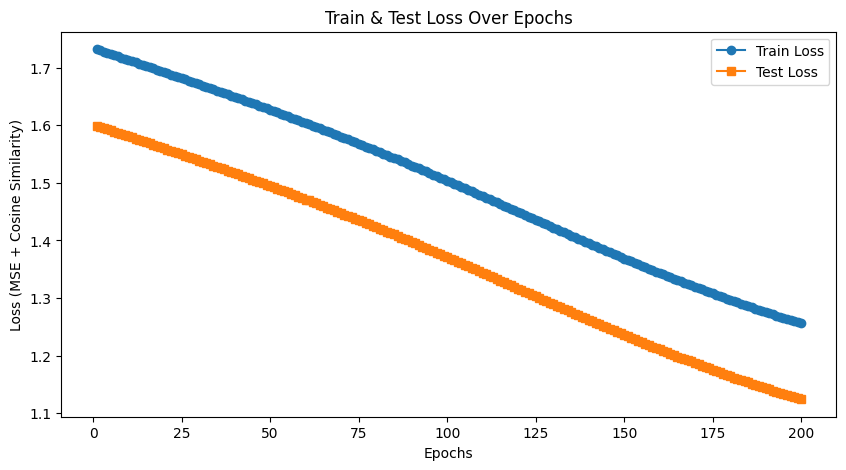

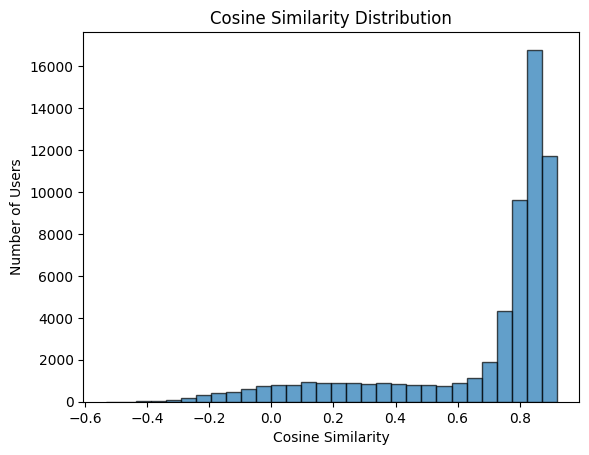

In [12]:
# 🔹 Step 8: Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE + Cosine Similarity)")
plt.title("Train & Test Loss Over Epochs")
plt.legend()
plt.show()



import matplotlib.pyplot as plt

plt.hist(cos_similarities, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Users")
plt.title("Cosine Similarity Distribution")
plt.show()
